# Predicting Word Analogies
* Author - Naren Srinivasan
* Date - March 09, 2019

## Table of Contents
* [Summary of results](#res)
* [fastText Word embeddings](#fasttext)
    * [Visualize embeddings](#emb-viz)
        * [Sample set of words](#emb-sample)
        * [Dimensionality reduction](#emb-dim)
        * [Plot of sample set of words](#emb-plot)
    * [Word Analogy Prediction](#analogy-pred)
        * [Validation](#analogy-validate)

## Summary of results <a class="anchor" id="res"></a>

* ACCURACY (% of CORRECT predictions) - **87.6 %**

## fastText Word embeddings <a class="anchor" id="fasttext"></a>

In [1]:
# loading the pre-trained word vector
from __future__ import print_function
import gensim
print(gensim.__version__)


3.4.0


In [ ]:
from gensim.models import KeyedVectors

emb_model = KeyedVectors.load_word2vec_format('./embeddings/fasttext/fasttext_1M_word.vec')

In [3]:
# Getting the tokens 
words = []
for word in emb_model.vocab:
    words.append(word)

# Printing out number of tokens available
print("Number of Tokens: {}".format(len(words)))

Number of Tokens: 999994


### Visualize embeddings <a class="anchor" id="emb-viz"></a>

Word emebeddings, which are essentially a high-dimensional numerical representation of a word based on the context it is typically used in, can be visualized by performing a dimensionality reduction on the embedding vector.

Words which are used in similar contexts will be closer, and those used in disparate contexts will be further away. For example, 'man' and 'boy' will be closer than 'man' and 'girl'

In [34]:
import numpy as np

#### Sample set of words from vocabulary and associated embeddings <a class="anchor" id="emb-sample"></a>

In [51]:
def get_sample_words_embeddings(emb_model, size = 100, dim = 300):
     """
    Gets a sample of words from the vocabulary and their associated embeddings
    
    Args:
        emb_model - Word embedding model
        size - Size of sample
        dim - Dimension of embeddings
        
    Returns:
       A dictionary of sample words, and the embedding matrix for all the sample words
    """
    
    sample_words_keys = np.random.choice(list(emb_model.vocab.keys()), size = size)

    sample_words = {k : emb_model.vocab[k] for k in sample_words_keys}

    embedding = np.array([])

    for word in sample_words:
        embedding = np.append(embedding, emb_model[word])
    embedding = embedding.reshape(size, dim)
    
    return sample_words, embedding


dim = 300
size = 100
sample_words, embeddings = get_sample_words_embeddings(emb_model)

#### Dimensionality reduction using t-SNE <a class="anchor" id="emb-dim"></a>

In [52]:
from sklearn.manifold import TSNE

In [55]:
dim_red_model = TSNE(perplexity = 30, n_components = 2, init = 'pca', n_iter = 10000)

In [ ]:
low_dim_embedding = dim_red_model.fit_transform(embeddings)

#### Plot of the sample set of words and their embeddings [Relative similarity] <a class="anchor" id="emb-plot"></a>

In [ ]:
import matplotlib.pyplot as plt

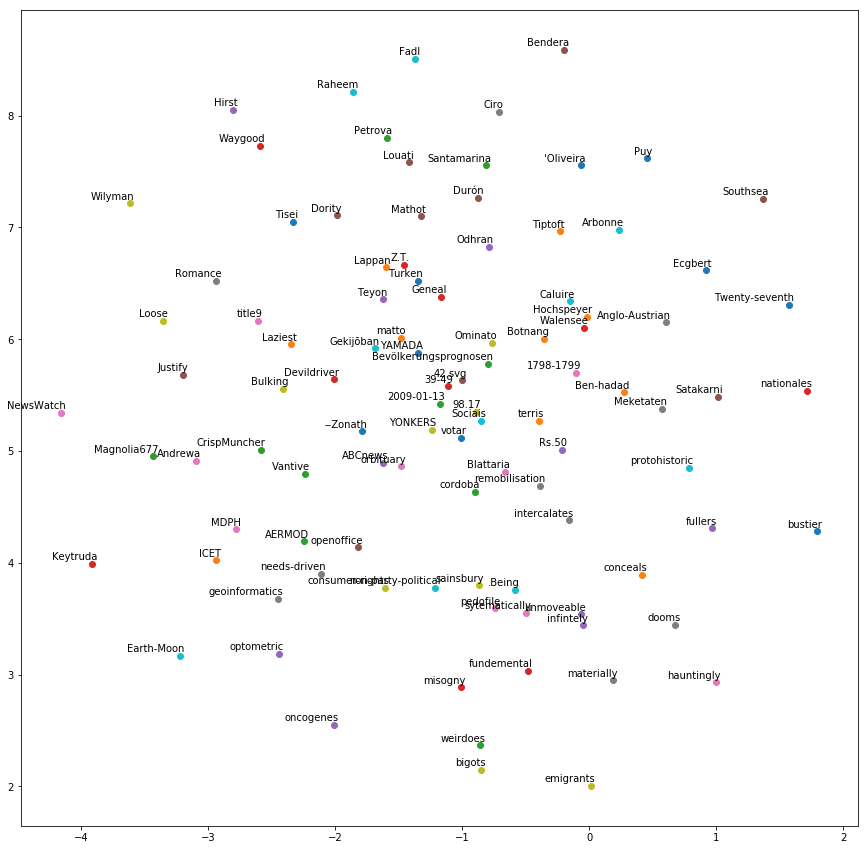

In [66]:
def plot_emb(low_dim_emb, words):
         """
    Plots word embeddings in a 2-D space
    
    Args:
        low_dim_emb - Low dimensional (2D) version of the word embedding
        words - a dictionary of words to be plotted
        
    Returns:
       A of relative distances of word emebeddings in 2D
    """
    plt.figure(figsize = (15,15))
    
    for i, word in enumerate(words):
        x, y = low_dim_emb[i, :]
        plt.scatter(x,y)
        plt.annotate(word,
                    xy = (x,y),
                    xytext = (5,2),
                    textcoords = 'offset points',
                    ha = 'right',
                    va = 'bottom')
    return plt

plt = plot_emb(low_dim_embedding, sample_words)
plt.show()

## Word analogy prediction - Similarity between fastText emebeddings <a class="anchor" id="analogy-pred"></a>

In [78]:
def get_analogy(example, query, emb_model):
         """
    Obtains the analogy of a word based on an example
    
    Args:
        example - a list of two words illustrating the example
        query - The word whose analogy is to be found
        emb_model - The word embedding model
        
    Returns:
      The analogous word
    """
    word_positive = [query, example[1]]
    word_negative = [example[0]]
 
    analogy = emb_model.most_similar(positive = word_positive,
                                            negative = word_negative,
                                            topn = 1)
        #print("Word : {0} , Similarity: {1:.2f}".format(
        #    analogy[0], analogy[1]
        #))
    return analogy[0][0]


In [79]:
# Word analogies
example = ['boy', 'man']
query = 'girl'

get_analogy(example, query, emb_model)

'woman'

In [88]:
example = ['man', 'woman']
query = 'king'

get_analogy(example, query, emb_model)

'queen'

In [89]:
example = ['Japan', 'France']
query = 'Tokyo'

get_analogy(example, query, emb_model)

'Paris'

In [90]:
example = ['big', 'biggest']
query = 'old'

get_analogy(example, query, emb_model)

'oldest'

### Validation <a class="anchor" id="analogy-validate"></a>

In [67]:
import pandas as pd

In [70]:
val_data = pd.read_csv('./data/google_analogy_test_set.txt', sep=" ", header=None)
val_data.columns = ["e1", "e2", "q", "a"]

In [71]:
val_data.head()

,e1,e2,q,a
0,Athens,Greece,Baghdad,Iraq
1,Athens,Greece,Bangkok,Thailand
2,Athens,Greece,Beijing,China
3,Athens,Greece,Berlin,Germany
4,Athens,Greece,Bern,Switzerland


In [80]:
def get_analogy_by_row(row):
         """
    Obtains the word analogies for all word analogy queries in a dataset
    
    Args:
         row - A row of a data frame containing the 2 words for the example, and the query
        
    Returns:
       The word analogy
    """
    example = [row['e1'], row['e2']]
    query = row['q']
    pred_answer = get_analogy(example, query, emb_model)
    return(pred_answer)

val_data['pred'] = val_data.apply(get_analogy_by_row, axis = 1)

In [85]:
val_data.head()

,e1,e2,q,a,pred,is_accurate
0,Athens,Greece,Baghdad,Iraq,Iraq,1
1,Athens,Greece,Bangkok,Thailand,Thailand,1
2,Athens,Greece,Beijing,China,China,1
3,Athens,Greece,Berlin,Germany,Germany,1
4,Athens,Greece,Bern,Switzerland,Switzerland,1


In [84]:
val_data['is_accurate'] = val_data.apply(lambda r : 1 if r.a == r.pred else 0, axis = 1)

In [86]:
val_data.to_csv('./data/google_analogy_test_set_with_predictions.csv')

In [ ]:
val_data = pd.read_csv('./data/google_analogy_test_set_with_predictions.csv')

In [87]:
accuracy = val_data['is_accurate'].sum()/ len(val_data) * 100
print('% of CORRECT predictions: ', accuracy, ' %')

% of CORRECT predictions:  87.59209987720017  %
